# Keras MobileNet Benchmark

In a previous benchmark we used a simple three layer ConvNet. This time we use a deeper MobileNet architecture on greyscale strokes. 

This kernel has three main components:

* MobileNet
* Fast and memory efficient Image Generator with temporal colored strokes
* Full training & submission with Kaggle Kernel

I did some paramer search but it should not be hard to improve the current score.

## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'

DP_DIR = 'E:/quick_draw/train_pb/'
INPUT_DIR = 'E:/quick_draw/'



BASE_SIZE = 256
NCSVS = 20
NCATS = 3
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'bear'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=2):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=2):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [4]:
STEPS = 100
EPOCHS = 5
size = 128
batchsize = 256

In [6]:
model = Conv2D(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
print(model.summary())

TypeError: __init__() missing 2 required positional arguments: 'filters' and 'kernel_size'

## Training with Image Generator

In [286]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_pb_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [287]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_pb_k{}.csv.gz'.format(NCSVS - 1)), nrows=2800)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(2800, 128, 128, 1) (2800, 3)
Validation array memory 0.17 GB


In [288]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [289]:
np.size(train_datagen)

1

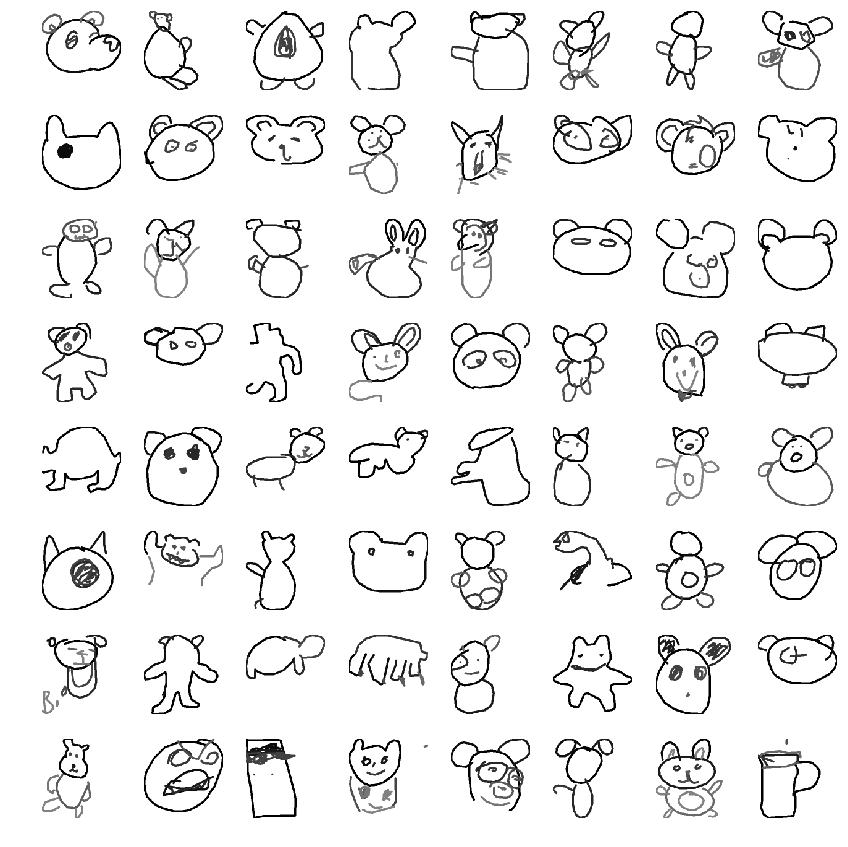

In [290]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [291]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]

In [ ]:
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data = (x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/5
 10/100 [==>...........................] - ETA: 55:44 - loss: 1.1474 - categorical_crossentropy: 1.1474 - categorical_accuracy: 0.4918

In [272]:
hists

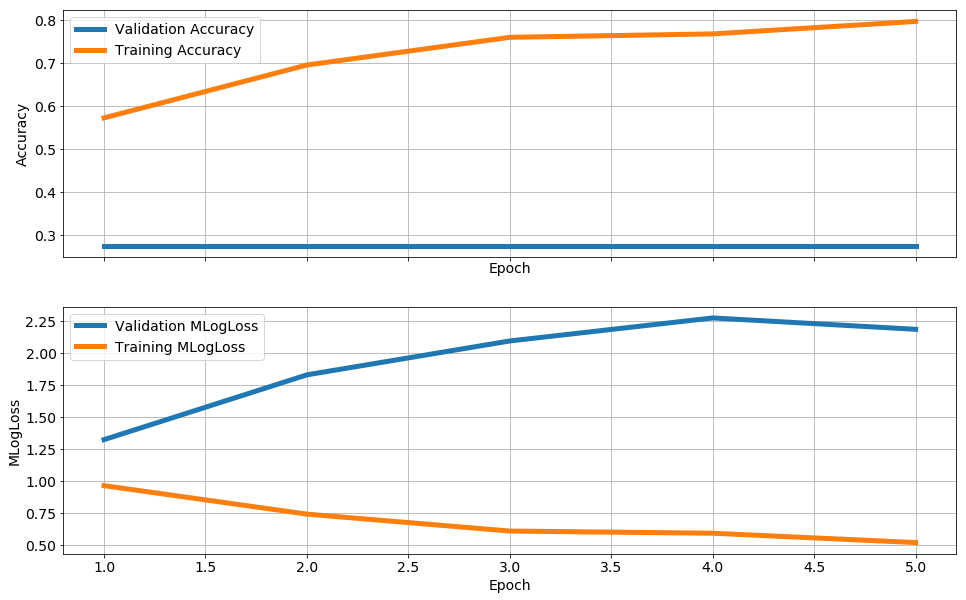

In [267]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [260]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

2800/2800 [==============================] - 22s 8ms/step
Map3: 0.486


In [261]:
pd.DataFrame(valid_predictions).to_csv("preds.csv")

In [173]:
valid_df = pd.concat([valid_df,pd.DataFrame(valid_predictions)], axis=1)

In [187]:
t = valid_df[valid_df['word']=='tornado']['countrycode'].unique()

In [188]:
h = valid_df[valid_df['word']=='hurricane']['countrycode'].unique()

In [189]:
set(t)-set(h)

{'CY', 'GG', 'GT', 'JE', 'JO', 'MA', 'ME', 'MK', 'NP', 'OM', 'PR', 'UY'}

In [191]:
len(set(h))

74

## Create Submission

In [262]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 128, 128, 1)
Test array memory 6.85 GB


In [263]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

112199/112199 [==============================] - 702s 6ms/step


In [271]:
model

In [270]:
np.unique(x_test)

array([-1.        , -0.75686276, -0.7254902 , -0.7019608 , -0.6784314 ,
       -0.654902  , -0.62352943, -0.6       , -0.5764706 , -0.5529412 ,
       -0.52156866, -0.5058824 , -0.49803922, -0.48235294, -0.45882353,
       -0.43529412, -0.40392157, -0.38039216, -0.35686275, -0.33333334,
       -0.3019608 , -0.2784314 , -0.2627451 , -0.25490198, -0.23921569,
       -0.23137255, -0.21568628, -0.2       , -0.18431373, -0.1764706 ,
       -0.16078432, -0.15294118, -0.13725491, -0.12941177, -0.11372549,
       -0.09803922, -0.08235294, -0.07450981, -0.05882353, -0.05098039,
       -0.03529412, -0.02745098, -0.01960784, -0.01176471,  0.00392157,
        0.01960784,  0.03529412,  0.04313726,  0.05882353,  0.06666667,
        0.08235294,  0.09019608,  0.10588235,  0.12156863,  0.13725491,
        0.14509805,  0.16078432,  0.16862746,  0.18431373,  0.19215687,
        0.20784314,  0.22352941,  0.23921569,  0.24705882,  0.2627451 ,
        0.27058825,  0.28627452,  0.29411766,  0.30980393,  0.32

In [266]:
#test_predictions = model.predict(x_test, batch_size=128, verbose=1)
top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + top3cats['c'] 
submission = test[['key_id', 'word']]
submission.to_csv('bear_mn_submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,a,b,c
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


(112199, 3)

,a,b,c
0,panda,teddy-bear,bear
1,panda,teddy-bear,bear
2,panda,teddy-bear,bear
3,panda,teddy-bear,bear
4,panda,teddy-bear,bear


(112199, 3)

,key_id,word
0,9000003627287624,panda teddy-bearbear
1,9000010688666847,panda teddy-bearbear
2,9000023642890129,panda teddy-bearbear
3,9000038588854897,panda teddy-bearbear
4,9000052667981386,panda teddy-bearbear


(112199, 2)

In [156]:
test['word'].unique()

array(['tornado hurricane'], dtype=object)

In [142]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] 
submission = test[['key_id', 'word']]
submission.to_csv('hurricane_gs_mn_submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,hurricane tornado
1,9000010688666847,hurricane tornado
2,9000023642890129,hurricane tornado
3,9000038588854897,hurricane tornado
4,9000052667981386,hurricane tornado


(112199, 2)

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))